In [5]:
import os
import glob
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = 1
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.compat.v1.InteractiveSession(config=config)

# tf.debugging.enable_check_numerics()

import keras
import random
import numpy as np
import matplotlib.pyplot as plt

I0000 00:00:1738528058.424708  572805 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3794 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
H = 256
W = 256
C = 3
h = 8

P = 16     
assert(H == W)
assert(H % P == 0)

D_model = 1024
D_head = 128
D_fcn = 2048   
num_layers = 4

N = (H * W) // (P * P)
BATCH_SIZE = 16
FLOAT = tf.float32

In [7]:
def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [8]:
def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H - 100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 50, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 50, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)

    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(
            [
                tf.repeat(tf.range(y1, y2), x2 - x1),
                tf.tile(tf.range(x1, x2), [y2 - y1]),
            ],
            axis=-1,
        ),
        updates=tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.bool),
    )
    return tf.expand_dims(mask, -1)  # expand channel wise


ds_shape_advertised = (512, 512, 3)

def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(ds_shape_advertised)))

    return img, is_valid


dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 50


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate)
dataset = dataset.filter(lambda img, is_valid: is_valid)
dataset = dataset.map(lambda img, is_valid: img) 
dataset = dataset.map(lambda img: tf.image.resize(img, (H, W)))

with tf.device("/cpu:0"):
    valid_count = dataset.reduce(
        tf.constant(0, dtype=tf.int32), lambda x, _: x + 1
    ).numpy() # type: ignore

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

masks = [random_visibility_mask() for _ in range(valid_count)]
mask_dataset = tf.data.Dataset.from_tensor_slices(masks)

ds_masks = tf.data.Dataset.zip((dataset,mask_dataset))

train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds_masks.take(train_count).batch(BATCH_SIZE)
test_ds = ds_masks.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = ds_masks.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)

train_batches = -(train_count // -BATCH_SIZE)
test_batches =  -(test_count // -BATCH_SIZE)
val_batches =  -(val_count // -BATCH_SIZE)

print("T,T,V:",train_count, test_count, val_count)

Valid images count: 50
T,T,V: 40 5 5


In [9]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],  
        strides=[1, P, P, 1], 
        rates=[1, 1, 1, 1], 
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x P^2 x C} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image

    
sample = tf.expand_dims(next(iter(dataset.take(1))), 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample)) , sample)

def create_attention_mask(obvmask: tf.Tensor):
    "R^{BS x H x W} -> R^{BS x N x N}"
    # TF does not support native min pooling.
    # The mask shown is OBSERVATION MASK meaning 0 means missing.

    BS = tf.shape(obvmask)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(
            tf.logical_not(obvmask), dtype=tf.int8
        ),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )



    return A

# create_attention_mask(tf.expand_dims(random_visibility_mask(),0))

In [10]:
commonDense = {"dtype": FLOAT, "kernel_initializer": "he_normal"}

class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(D_model, **commonDense)  # (P² * C) -> D_model

    def build(self, input_shape):
        positions = tf.range(N, dtype=FLOAT)
        positions = tf.expand_dims(positions, 1)  # (N, 1)
        i = tf.range(D_model // 2, dtype=FLOAT)
        div_term = tf.exp((2.0 * i) * (-tf.math.log(10000.0) / D_model))
        angles = positions * div_term  # (N, D_model//2)
        sin_terms = tf.sin(angles)
        cos_terms = tf.cos(angles)

        self.positional_embedding = tf.reshape(
            tf.stack([sin_terms, cos_terms], axis=-1), [N, D_model]
        )
        # tf.print(self.positional_embedding)

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, **commonDense)
        self.W_K = keras.layers.Dense(h * D_head, **commonDense)
        self.W_V = keras.layers.Dense(h * D_head, **commonDense )
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, **commonDense)

    def call(self, X, A):
        # X: R^{BS x N x D_model}
        # A: R^{BS x N x N}
        # returns: R^{BS x N x D_model}

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(D_fcn, activation="gelu", **commonDense),
                keras.layers.Dense(D_model, **commonDense),
                # keras.layers.Dropout(0.1, dtype=FLOAT),
            ],
        )

    def call(self, X, A):
        "R^{N x D_model} -> R^{N x D_model}"
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X


class Decoder(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(P * P * C, **commonDense)

    def call(self, X):
        "R^{BS x N x D_model} -> R^{BS x N x P x P x C}"
        BS = tf.shape(X)[0]
        X = self.proj(X)
        X = tf.reshape(X, (BS, N, P, P, C))
        return X


class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obvmask):
        image = tf.multiply(image, tf.cast(obvmask, FLOAT))
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obvmask)
        # viz_img(A)

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)
        reconstructed_patches = self.decoder(X)  # R^{BS x N x P x P x C}
        return patches_to_imgs(reconstructed_patches)


model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
model.summary()

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │       787,456 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     8,399,872 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       787,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,174,144 (134.18 MB)

 Trainable params: 35,174,144 (134.18 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# model.load_weights("best_run.keras")

In [12]:
session_epochs = 0

In [13]:
@tf.function
def costfunc(y_true: tf.Tensor, y_pred: tf.Tensor, obsvmask: tf.Tensor):
    errors = tf.abs(tf.subtract(y_true, y_pred))
    inpaintmask = tf.cast(tf.logical_not(obsvmask), FLOAT)
    masked_errors = tf.multiply(errors, inpaintmask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(inpaintmask)
    masked_loss = sum_masked_errors / (area + keras.backend.epsilon())

    # global_loss = tf.reduce_mean(errors)
    # return masked_loss + global_loss
    return masked_loss


# optimizer = keras.optimizers.AdamW(
#     learning_rate=3e-4,
#     weight_decay=0.05,
#     clipvalue=1.0
# )
optimizer = keras.optimizers.Adam(learning_rate=1e-5 , clipvalue=1.0)

@tf.function
def train_step(image: tf.Tensor, mask: tf.Tensor):
    with tf.GradientTape() as tape:
        reconstructed_img = model(image, mask)  # N x P x P x C
        loss = costfunc(image, reconstructed_img, mask)
        tf.debugging.check_numerics(loss, "Loss contains NaN or Inf.")
        # if (tf.math.is_nan(loss)):
        # raise Exception("Divergence")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(image: tf.Tensor, mask: tf.Tensor):
    reconstructed_img = model(image, mask, training=False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss


epochs = 50

print("Starting training")

best_val_loss = float("inf")
best_epoch = -1
for _ in range(epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(
        train_ds,
        desc=f"Epoch {session_epochs+1}",
        unit="batch",
        total=train_batches,
    )
    for image_batch, mask_batch in pbar:
        loss = train_step(image_batch, mask_batch)
        epoch_loss += loss
        steps += 1
        # Dynamically update the tqdm bar without spamming stdout
        pbar.set_postfix(loss=f"{loss:.4f}")
    train_loss = epoch_loss / steps

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(
        val_ds,
        desc=f"Epoch {session_epochs+1} Validation",
        unit="batch",
        total=val_batches,
    )
    for val_image_batch, val_mask_batch in pbar_val:
        loss = val_step(val_image_batch, val_mask_batch)
        val_loss_total += loss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{loss:.4f}")
        
    avg_val_loss = val_loss_total / val_steps
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")
    print(
        f"Epoch {session_epochs+1} Summary: Train Loss = {train_loss:.4f} | Validation Loss = {avg_val_loss:.4f}"
    )
    session_epochs += 1

Starting training


Epoch 1 Validation: 100%|██████████| 1/1 [00:01<00:00,  1.02s/batch, loss=2.9989]


Epoch 1 Summary: Train Loss = 3.3418 | Validation Loss = 2.9989


Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.62batch/s, loss=2.6100]


Epoch 2 Summary: Train Loss = 2.7631 | Validation Loss = 2.6100


Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.50batch/s, loss=2.3365]


Epoch 3 Summary: Train Loss = 2.4400 | Validation Loss = 2.3365


Epoch 4 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.30batch/s, loss=2.1078]


Epoch 4 Summary: Train Loss = 2.1923 | Validation Loss = 2.1078


Epoch 5 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.41batch/s, loss=1.9153]


Epoch 5 Summary: Train Loss = 1.9862 | Validation Loss = 1.9153


Epoch 6 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.60batch/s, loss=1.7406]


Epoch 6 Summary: Train Loss = 1.8088 | Validation Loss = 1.7406


Epoch 7 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.96batch/s, loss=1.5895]


Epoch 7 Summary: Train Loss = 1.6519 | Validation Loss = 1.5895


Epoch 8 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.62batch/s, loss=1.4615]


Epoch 8 Summary: Train Loss = 1.5184 | Validation Loss = 1.4615


Epoch 9 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.00batch/s, loss=1.3527]


Epoch 9 Summary: Train Loss = 1.4050 | Validation Loss = 1.3527


Epoch 10 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.46batch/s, loss=1.2585]


Epoch 10 Summary: Train Loss = 1.3073 | Validation Loss = 1.2585


Epoch 11 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.33batch/s, loss=1.1787]


Epoch 11 Summary: Train Loss = 1.2240 | Validation Loss = 1.1787


Epoch 12 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.65batch/s, loss=1.1066]


Epoch 12 Summary: Train Loss = 1.1545 | Validation Loss = 1.1066


Epoch 13 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.62batch/s, loss=1.0417]


Epoch 13 Summary: Train Loss = 1.0946 | Validation Loss = 1.0417


Epoch 14 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.06batch/s, loss=0.9870]


Epoch 14 Summary: Train Loss = 1.0444 | Validation Loss = 0.9870


Epoch 15 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.39batch/s, loss=0.9415]


Epoch 15 Summary: Train Loss = 1.0037 | Validation Loss = 0.9415


Epoch 16 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.44batch/s, loss=0.9039]


Epoch 16 Summary: Train Loss = 0.9706 | Validation Loss = 0.9039


Epoch 17 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.38batch/s, loss=0.8733]


Epoch 17 Summary: Train Loss = 0.9434 | Validation Loss = 0.8733


Epoch 18 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.65batch/s, loss=0.8471]


Epoch 18 Summary: Train Loss = 0.9211 | Validation Loss = 0.8471


Epoch 19 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.60batch/s, loss=0.8245]


Epoch 19 Summary: Train Loss = 0.9022 | Validation Loss = 0.8245


Epoch 20 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.73batch/s, loss=0.8056]


Epoch 20 Summary: Train Loss = 0.8864 | Validation Loss = 0.8056


Epoch 21 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.63batch/s, loss=0.7885]


Epoch 21 Summary: Train Loss = 0.8742 | Validation Loss = 0.7885


Epoch 22 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.65batch/s, loss=0.7733]


Epoch 22 Summary: Train Loss = 0.8644 | Validation Loss = 0.7733


Epoch 23 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.64batch/s, loss=0.7607]


Epoch 23 Summary: Train Loss = 0.8564 | Validation Loss = 0.7607


Epoch 24 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.47batch/s, loss=0.7504]


Epoch 24 Summary: Train Loss = 0.8498 | Validation Loss = 0.7504


Epoch 25 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.25batch/s, loss=0.7424]


Epoch 25 Summary: Train Loss = 0.8444 | Validation Loss = 0.7424


Epoch 26 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.05batch/s, loss=0.7357]


Epoch 26 Summary: Train Loss = 0.8399 | Validation Loss = 0.7357


Epoch 27 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.27batch/s, loss=0.7296]


Epoch 27 Summary: Train Loss = 0.8360 | Validation Loss = 0.7296


Epoch 28 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.59batch/s, loss=0.7239]


Epoch 28 Summary: Train Loss = 0.8325 | Validation Loss = 0.7239


Epoch 29 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.15batch/s, loss=0.7190]


Epoch 29 Summary: Train Loss = 0.8293 | Validation Loss = 0.7190


Epoch 30 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.45batch/s, loss=0.7146]


Epoch 30 Summary: Train Loss = 0.8263 | Validation Loss = 0.7146


Epoch 31 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.54batch/s, loss=0.7106]


Epoch 31 Summary: Train Loss = 0.8235 | Validation Loss = 0.7106


Epoch 32 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.81batch/s, loss=0.7067]


Epoch 32 Summary: Train Loss = 0.8211 | Validation Loss = 0.7067


Epoch 33 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.68batch/s, loss=0.7031]


Epoch 33 Summary: Train Loss = 0.8189 | Validation Loss = 0.7031


Epoch 34 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.55batch/s, loss=0.6998]


Epoch 34 Summary: Train Loss = 0.8169 | Validation Loss = 0.6998


Epoch 35 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.63batch/s, loss=0.6967]


Epoch 35 Summary: Train Loss = 0.8150 | Validation Loss = 0.6967


Epoch 36 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.71batch/s, loss=0.6939]


Epoch 36 Summary: Train Loss = 0.8131 | Validation Loss = 0.6939


Epoch 37 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.69batch/s, loss=0.6913]


Epoch 37 Summary: Train Loss = 0.8113 | Validation Loss = 0.6913


Epoch 38 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.58batch/s, loss=0.6888]


Epoch 38 Summary: Train Loss = 0.8094 | Validation Loss = 0.6888


Epoch 39 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.12batch/s, loss=0.6866]


Epoch 39 Summary: Train Loss = 0.8076 | Validation Loss = 0.6866


Epoch 40 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.19batch/s, loss=0.6845]


Epoch 40 Summary: Train Loss = 0.8057 | Validation Loss = 0.6845


Epoch 41 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.47batch/s, loss=0.6825]


Epoch 41 Summary: Train Loss = 0.8038 | Validation Loss = 0.6825


Epoch 42 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.11batch/s, loss=0.6806]


Epoch 42 Summary: Train Loss = 0.8019 | Validation Loss = 0.6806


Epoch 43 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.07batch/s, loss=0.6786]


Epoch 43 Summary: Train Loss = 0.7998 | Validation Loss = 0.6786


Epoch 44 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.50batch/s, loss=0.6768]


Epoch 44 Summary: Train Loss = 0.7977 | Validation Loss = 0.6768


Epoch 45 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.60batch/s, loss=0.6750]


Epoch 45 Summary: Train Loss = 0.7956 | Validation Loss = 0.6750


Epoch 46 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.66batch/s, loss=0.6731]


Epoch 46 Summary: Train Loss = 0.7934 | Validation Loss = 0.6731


Epoch 47 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.71batch/s, loss=0.6714]


Epoch 47 Summary: Train Loss = 0.7911 | Validation Loss = 0.6714


Epoch 48 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.36batch/s, loss=0.6694]


Epoch 48 Summary: Train Loss = 0.7888 | Validation Loss = 0.6694


Epoch 49 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.76batch/s, loss=0.6677]


Epoch 49 Summary: Train Loss = 0.7864 | Validation Loss = 0.6677


Epoch 50 Validation: 100%|██████████| 1/1 [00:00<00:00,  7.42batch/s, loss=0.6656]


Epoch 50 Summary: Train Loss = 0.7840 | Validation Loss = 0.6656


In [14]:
# model.save("br3.keras")
# model.load_weights("best_run.keras")

In [15]:
def apply_obsv_mask(image: tf.Tensor, obvmask: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, tf.cast(obvmask, FLOAT))


def viz_grid(batch: tf.Tensor):
    batch_size: int = batch.shape[0]  # type: ignore
    fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(15, 15), dpi=300)
    if batch_size == 1:
        axes = [axes]
    for i in range(batch_size):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy() # type: ignore
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def reconstruct(original: tf.Tensor, reconstruct: tf.Tensor, obvmask: tf.Tensor):
    return tf.add(
        tf.multiply(tf.cast(obvmask, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obvmask), FLOAT), reconstruct),
    )

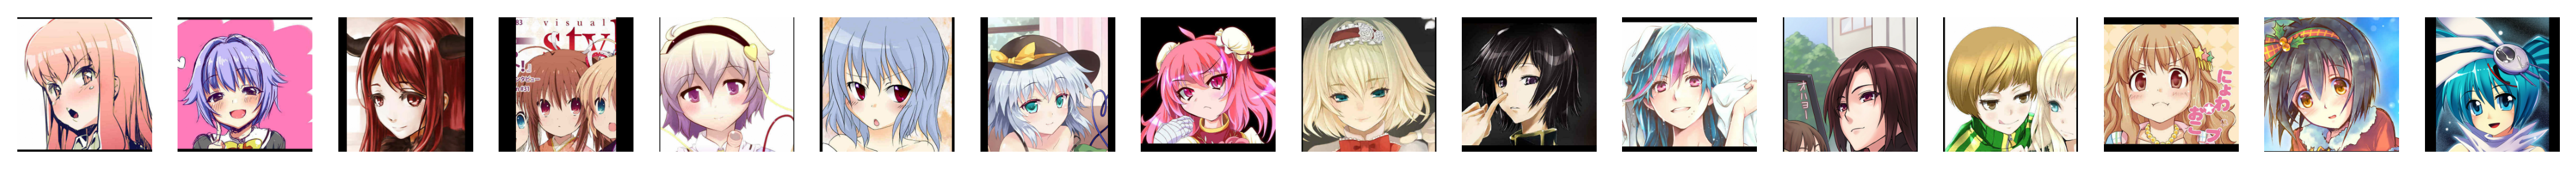

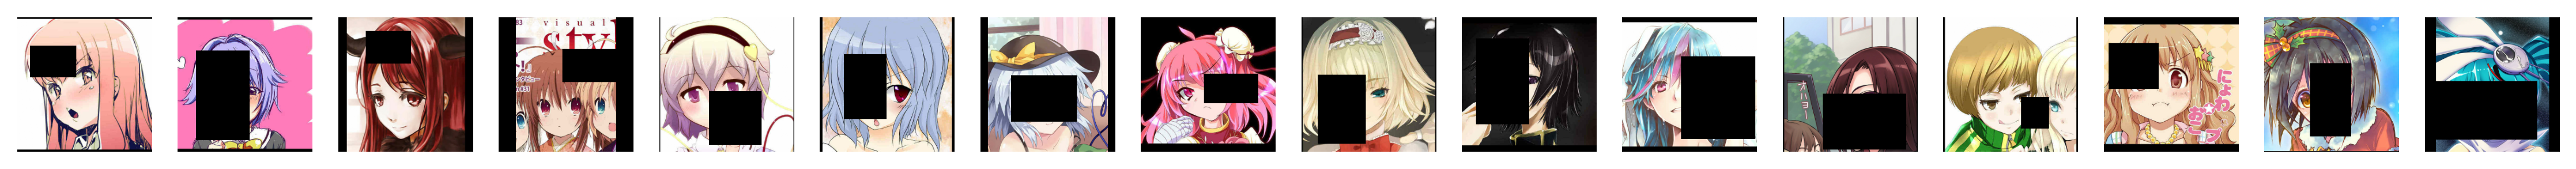

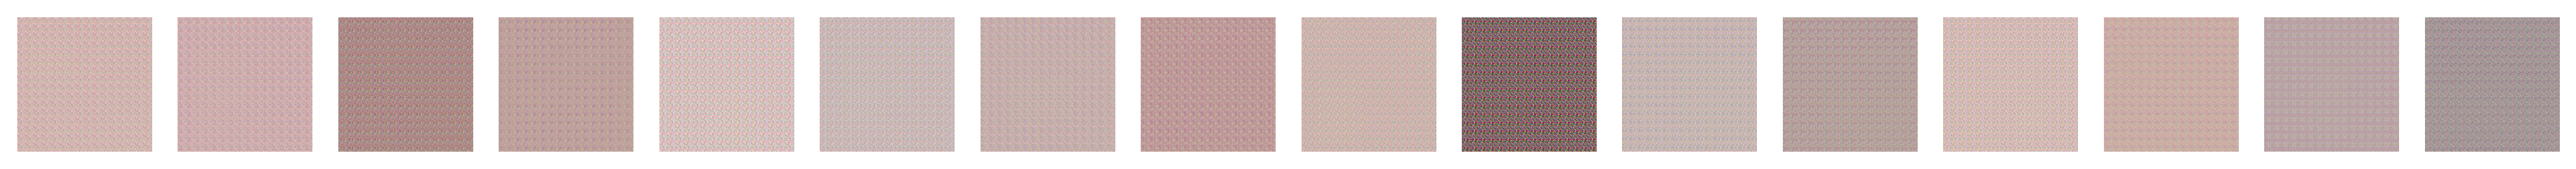

In [16]:
img, obvmask = next(iter(train_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obvmask))
model_out = model(img, obvmask)
# reconstructed = reconstruct(img, model(img, obvmask), obvmask)
viz_grid(model_out)

# viz_img(model_out[0])
# viz_img(img[0])

In [17]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))

